## MA5852 Assessment 3 - Capstone Report
### Notebook 1 - CNN Model

#### Part 1.1
This section contains commands from the Jupyter terminal and will not work directly from the notebook. The purpose is to create the necessary directories and files required for the training and evaluation of both CNNs.

In [ ]:
# navigate to the data directory in SageMaker
cd SageMaker/data

# create a new directory for the dataset
mkdir A3

# the dataset is being sourced from kaggle (https://www.kaggle.com/arunrk7/surface-crack-detection) as the original location
# uses a rar file within the zipped folder (https://data.mendeley.com/datasets/5y9wdsg2zt/2)

In [ ]:
# unzip it
unzip archive.zip

# create new training, validation and testing directories
mkdir train test val

# create a sub-directory for each of the outcomes classes inside the validation and testing directories
mkdir -p test/neg test/pos val/neg val/pos

# move 3,000 random images from the Negative and Positive directories into the appropriate sub-directories inside the
# validation and testing directories
ls Negative | sort -R |tail -3000 | while read file; do mv Negative/$file test/neg; done
ls Positive | sort -R |tail -3000 | while read file; do mv Positive/$file test/pos; done
ls Positive | sort -R |tail -3000 | while read file; do mv Positive/$file val/pos; done
ls Negative | sort -R |tail -3000 | while read file; do mv Negative/$file val/neg; done

# move the remaining images into the training directory
mv Positive train/pos
mv Negative train/neg

# check that everything has worked
du -h

# download im2rec.py and install mxnet
wget https://raw.githubusercontent.com/apache/incubator-mxnet/master/tools/im2rec.py
pip install mxnet opencv-python

# build list files for each of the subsets and move them to their own directories
python3 im2rec.py --list --recursive crack-train train
python3 im2rec.py --list --recursive crack-val val
python3 im2rec.py --list --recursive crack-test test

mkdir train_lst val_lst test_lst
mv crack-train.lst train_lst
mv crack-val.lst val_lst
mv crack-test.lst test_lst

# do another check of the directory
du -h

# upload everything to S3
aws s3 sync train s3://sagemaker-ap-southeast-2-987959606453/A3/input/train
aws s3 sync train_lst s3://sagemaker-ap-southeast-2-987959606453/A3/input/train_lst

aws s3 sync val s3://sagemaker-ap-southeast-2-987959606453/A3/input/val
aws s3 sync val_lst s3://sagemaker-ap-southeast-2-987959606453/A3/input/val_lst

aws s3 sync test s3://sagemaker-ap-southeast-2-987959606453/A3/input/test
aws s3 sync test_lst s3://sagemaker-ap-southeast-2-987959606453/A3/input/test_lst

#### Part 1.2
The purpose of the next section is just to take a look at a couple of images from the dataset.

In [3]:
# import necessary libraries and environments for this section
import matplotlib.pyplot as plt
import sagemaker
import tensorflow as tf

from matplotlib.pyplot import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator

sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
prefix = "A3"

In [4]:
print(tf.__version__)

1.15.5


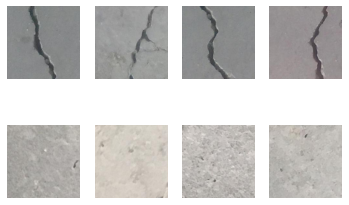

In [5]:
# take a look at a couple of images from both classes
pos_img_path = './data/A3/Positive/'
neg_img_path = './data/A3/Negative/'

for i in range(1,5):
    plt.subplot(240 + i)
    filename = pos_img_path + '0000' + str(i) + '.jpg'   
    img = imread(filename)
    plt.imshow(img)
    plt.axis("off")
    
for i in range(1,5):
    plt.subplot(244 + i)
    filename = neg_img_path + '0000' + str(i) + '.jpg'   
    img = imread(filename)
    plt.imshow(img)
    plt.axis("off")

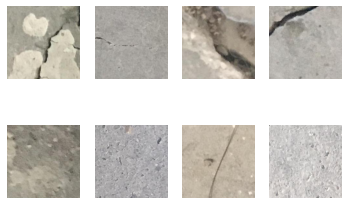

In [6]:
# look at a couple of other images for dataset quality assessment
pos_img = ['00339', '01360', '16004_1', '16564_1']
neg_img = ['161', '015', '283', '257']
fig = plt.figure()

for i in range(1,5):
    plt.subplot(240 + i)
    filename = pos_img_path + pos_img[i-1] + '.jpg'
    img = imread(filename)
    plt.imshow(img)
    plt.axis("off")

for i in range(1,5):
    plt.subplot(244 + i)
    filename = neg_img_path + '00' + neg_img[i-1] + '.jpg'
    img = imread(filename)
    plt.imshow(img)
    plt.axis("off")

#### Part 2: Model Training in SageMaker

In [7]:
%%sh
ls -l

total 27420
drwxr-xr-x 4 ec2-user ec2-user     4096 Jun 14 00:28 1
drwxr-xr-x 4 ec2-user ec2-user     4096 Jun 15 23:02 2
-rw-rw-r-- 1 ec2-user ec2-user     5157 May 30 07:16 A2_baseline ANN model script.py
-rw-rw-r-- 1 ec2-user ec2-user     4434 May 31 05:26 A2_batch normalised ANN model script.py
-rw-rw-r-- 1 ec2-user ec2-user    85951 May 31 01:21 A2 Notebook 1.ipynb
-rw-rw-r-- 1 ec2-user ec2-user 11921804 Jun 12 10:27 A2 Notebook 2.ipynb
-rw-rw-r-- 1 ec2-user ec2-user  4552874 May 31 06:58 A2 Notebook 3.ipynb
-rw-rw-r-- 1 ec2-user ec2-user     4987 May 31 06:03 A2_regularised ANN model script.py
-rw-rw-r-- 1 ec2-user ec2-user     9191 Jun 16 00:38 A3_baseline CNN model script.py
-rw-rw-r-- 1 ec2-user ec2-user     9115 Jun 15 23:53 A3_baseline CNN model script-v2.py
-rw-rw-r-- 1 ec2-user ec2-user     8778 Jun 16 00:40 A3_inception model script.py
-rw-rw-r-- 1 ec2-user ec2-user 10632136 Jun 16 00:40 A3 Notebook 1.ipynb
-rw-rw-r-- 1 ec2-user ec2-user   742371 Jun 15 07:24 A3 Notebook 

In [12]:
# import necessary libraries for this section
import itertools
import matplotlib.pyplot as plt
import numpy as np
import sagemaker
import tensorflow as tf
import time

from sagemaker.tensorflow import TensorFlow

In [9]:
# define environment variables
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
prefix = "A3"
tensorflow_logs_path = "s3://{}/{}/logs".format(bucket, prefix)
training_input_path = "s3://{}/{}/input/train/".format(bucket, prefix)
validation_input_path = "s3://{}/{}/input/val/".format(bucket, prefix)
output_path = "s3://{}/{}/output".format(bucket, prefix)

print("SageMaker ver: " + sagemaker.__version__)
print("Tensorflow ver: " + tf.__version__)
print("Bucket: {}".format(bucket))
print("Logs path: " + tensorflow_logs_path)
print("Training data location: " + training_input_path)
print("Validation data location: " + validation_input_path)
print("Output path: " + output_path)

SageMaker ver: 2.42.1
Tensorflow ver: 1.15.5
Bucket: sagemaker-ap-southeast-2-987959606453
Logs path: s3://sagemaker-ap-southeast-2-987959606453/A3/logs
Training data location: s3://sagemaker-ap-southeast-2-987959606453/A3/input/train/
Validation data location: s3://sagemaker-ap-southeast-2-987959606453/A3/input/val/
Output path: s3://sagemaker-ap-southeast-2-987959606453/A3/output


Testing whether the python script would run in SageMaker using local mode turned out not to be possible in this case so an initial test run was performed on a managed instance over a single epoch and with early-stopping turned off.

In [10]:
# define the metrics to be sent to CloudWatch
metric_definitions = [
    {'Name': 'training_loss',        'Regex': 'loss: ([0-9\\.]+)'},
    {'Name': 'training_accuracy',    'Regex': 'accuracy: ([0-9\\.]+)'},
    {'Name': 'training_precision',   'Regex': 'precision: ([0-9\\.]+)'},
    {'Name': 'training_recall',      'Regex': 'recall: ([0-9\\.]+)'},
    {'Name': 'training_auc',         'Regex': 'auc: ([0-9\\.]+)'},
    {'Name': 'validation_loss',      'Regex': 'val_loss: ([0-9\\.]+)'},
    {'Name': 'validation_accuracy',  'Regex': 'val_accuracy: ([0-9\\.]+)'},
    {'Name': 'validation_precision', 'Regex': 'val_precision: ([0-9\\.]+)'},
    {'Name': 'validation_recall',    'Regex': 'val_recall: ([0-9\\.]+)'},
    {'Name': 'validation_auc',       'Regex': 'val_auc: ([0-9\\.]+)'},
]

In [16]:
# configure the estimator
tf_estimator = TensorFlow(
    entry_point = 'A3_baseline CNN model script.py',
    role = role,
    source_dir = '.',
    instance_count = 1,
    instance_type = 'ml.p2.xlarge',    # the most powerful EC2 instance available to the author
    framework_version = '2.1.0',
    py_version = 'py3',
    script_mode = True,
    hyperparameters = {'optimiser': 'SGD', 'model-name': 'initial_model', 'tf-logs-path': tensorflow_logs_path,
                       'epochs': 20},
    metric_definitions = metric_definitions,
    output_path = output_path)

# and give it a name
training_job_name = 'A3-baseline-training-job-'+ time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [17]:
# fit the model in SageMaker
inputs = {'training': training_input_path,
          'validation': validation_input_path}

tf_estimator.fit(inputs, job_name=training_job_name)

2021-06-16 01:03:56 Starting - Starting the training job...
2021-06-16 01:03:58 Starting - Launching requested ML instancesProfilerReport-1623805151: InProgress
......
2021-06-16 01:05:24 Starting - Preparing the instances for training.........
2021-06-16 01:06:49 Downloading - Downloading input data........................
2021-06-16 01:10:48 Training - Downloading the training image...
2021-06-16 01:11:25 Training - Training image download completed. Training in progress.2021-06-16 01:11:15,483 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2021-06-16 01:12:14,523 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "training": "/opt/ml/input/data/training",
        "validation": "/opt/ml/input/data/validation"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"

Job ended with status 'Stopped' rather than 'Completed'. This could mean the job timed out or stopped early for some other reason: Consider checking whether it completed as you expect.


Training seconds: 645
Billable seconds: 645


In [93]:
# determine the name of this job
print(training_job_name)

A3-tuning-job-2021-06-15-22-17-50


In [340]:
# Training model name: A3-baseline-training-job-2021-06-13-23-23-31
# these results were copied from the model logs
train_loss = 0.055980894969750755
train_accuracy = 0.9870357
train_precision = 0.9895183
train_recall = 0.9845
train_auc = 0.99864894
val_loss = 0.06419987223566846
val_accuracy = 0.9838333
val_precision = 0.9852892
val_recall = 0.98233336
val_auc = 0.9978025
train_tn = 13854
train_fn = 217
train_tp = 13783
train_fp = 146
val_tn = 2956
val_fn = 53
val_tp = 2947
val_fp = 44

val_cm = np.array([[val_tn, val_fp],[val_fn,val_tp]])
train_cm = np.array([[train_tn, train_fp],[train_fn,train_tp]])

In [341]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[13854   146]
 [  217 13783]]


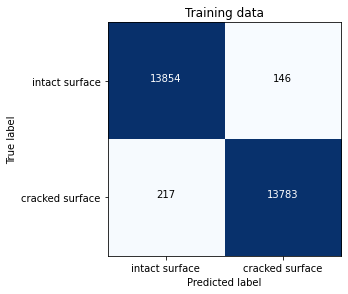

In [344]:
cm_plot_labels = ['intact surface', 'cracked surface']
plot_confusion_matrix(cm=train_cm, classes=cm_plot_labels, title='Training data')

[[2956   44]
 [  53 2947]]


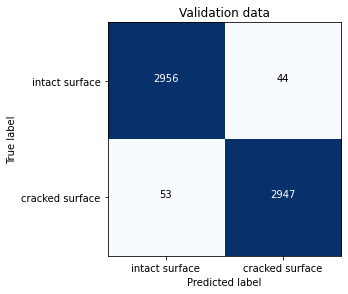

In [345]:
plot_confusion_matrix(cm=val_cm, classes=cm_plot_labels, title='Validation data')

#### Part 3: Hyperparameter Tuning

In [28]:
# import necessary libraries for this section
import boto3
import itertools
import numpy as np
import sagemaker
import tensorflow as tf
import time

from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.tensorflow import TensorFlow
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    IntegerParameter,
    HyperparameterTuner)

In [29]:
# re-define environment variables and metric definitions
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
prefix = "A3"
tensorflow_logs_path = "s3://{}/{}/logs".format(bucket, prefix)
training_input_path = "s3://{}/{}/input/train/".format(bucket, prefix)
validation_input_path = "s3://{}/{}/input/val/".format(bucket, prefix)
output_path = "s3://{}/{}/output".format(bucket, prefix)

metric_definitions = [
    {'Name': 'training_loss',        'Regex': 'loss: ([0-9\\.]+)'},
    {'Name': 'training_accuracy',    'Regex': 'accuracy: ([0-9\\.]+)'},
    {'Name': 'training_precision',   'Regex': 'precision: ([0-9\\.]+)'},
    {'Name': 'training_recall',      'Regex': 'recall: ([0-9\\.]+)'},
    {'Name': 'training_auc',         'Regex': 'auc: ([0-9\\.]+)'},
    {'Name': 'validation_loss',      'Regex': 'val_loss: ([0-9\\.]+)'},
    {'Name': 'validation_accuracy',  'Regex': 'val_accuracy: ([0-9\\.]+)'},
    {'Name': 'validation_precision', 'Regex': 'val_precision: ([0-9\\.]+)'},
    {'Name': 'validation_recall',    'Regex': 'val_recall: ([0-9\\.]+)'},
    {'Name': 'validation_auc',       'Regex': 'val_auc: ([0-9\\.]+)'},
]

In [30]:
# configure the tuning estimator
tf_estimator = TensorFlow(
    entry_point = 'A3_baseline CNN model script.py',
    role = role,
    source_dir = '.',
    instance_count = 1,
    instance_type = 'ml.p2.xlarge',
    framework_version = '2.1.0',
    py_version = 'py3',
    script_mode = True,
    hyperparameters = {'model-name': 'tuned_model', 'tf-logs-path': tensorflow_logs_path, 'epochs':20},
    metric_definitions = metric_definitions,
    output_path = output_path)

# and give it a name
training_job_name = 'A3-tuning-job-'+ time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

In [45]:
# only a small tuning job given the time required to train the model () and its purpose is just to validate the
# previous results rather than determine the optimal parameter configuration
# set-up the tuning job by first defining hyperparameters (and ranges)
hyperparameter_ranges = {
    'learning-rate': ContinuousParameter(0.0001, 0.1, scaling_type='ReverseLogarithmic'),
    'dense-layer': IntegerParameter(32, 256),
    'batch-size': IntegerParameter(8, 128),
    'optimizer': CategoricalParameter(['RMSprop', 'SGD', 'Adam', 'Nadam'])
}

# and also define the metrics
objective_metric_name = 'validation_accuracy'
objective_type = 'Maximize'

metric_definitions = [
    {'Name': 'training_loss',        'Regex': 'loss: ([0-9\\.]+)'},
    {'Name': 'training_accuracy',    'Regex': 'accuracy: ([0-9\\.]+)'},
    {'Name': 'training_precision',   'Regex': 'precision: ([0-9\\.]+)'},
    {'Name': 'training_recall',      'Regex': 'recall: ([0-9\\.]+)'},
    {'Name': 'training_auc',         'Regex': 'auc: ([0-9\\.]+)'},
    {'Name': 'validation_loss',      'Regex': 'val_loss: ([0-9\\.]+)'},
    {'Name': 'validation_accuracy',  'Regex': 'val_accuracy: ([0-9\\.]+)'},
    {'Name': 'validation_precision', 'Regex': 'val_precision: ([0-9\\.]+)'},
    {'Name': 'validation_recall',    'Regex': 'val_recall: ([0-9\\.]+)'},
    {'Name': 'validation_auc',       'Regex': 'val_auc: ([0-9\\.]+)'},
]

# and name the job
tuning_job_name = "A3-HPO-job-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())
    
# create the tuner
tuner = HyperparameterTuner(
    tf_estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=1,
    objective_type=objective_type,
    strategy="Bayesian",
    early_stopping_type="Auto")

In [ ]:
# define the input paths and run the tuner
inputs = {'training': training_input_path,
          'validation': validation_input_path}

tuner.fit(inputs, job_name=tuning_job_name)

In [58]:
# analyse the results
tuning_job_names = ['A3-HPO-job-2021-06-14-00-35-16', 'A3-HPO-job-2021-06-15-16-52-17', 'A3-HPO-job-2021-06-15-20-19-29']
tuner_metrics = HyperparameterTuningJobAnalytics(tuning_job_names[1])

full_metrics_df = tuner_metrics.dataframe()
top_metrics_df = full_metrics_df.sort_values(['FinalObjectiveValue'], ascending=False).head(10)
top_metrics_df

,batch-size,dense-layer,learning-rate,optimizer,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,88.0,32.0,0.027819,"""Nadam""",A3-HPO-job-2021-06-15-16-52-17-005-cc9ffdb7,Completed,0.5,2021-06-15 19:21:40+00:00,2021-06-15 20:11:19+00:00,2979.0
1,16.0,200.0,0.054622,"""Nadam""",A3-HPO-job-2021-06-15-16-52-17-004-7dd5d19d,Completed,0.5,2021-06-15 18:40:09+00:00,2021-06-15 19:15:50+00:00,2141.0
2,82.0,162.0,0.007313,"""RMSprop""",A3-HPO-job-2021-06-15-16-52-17-003-050ff397,Completed,0.5,2021-06-15 18:10:42+00:00,2021-06-15 18:37:14+00:00,1592.0
3,68.0,82.0,0.075530,"""SGD""",A3-HPO-job-2021-06-15-16-52-17-002-a841039f,Completed,0.5,2021-06-15 17:28:21+00:00,2021-06-15 18:06:06+00:00,2265.0
4,117.0,254.0,0.063564,"""Adam""",A3-HPO-job-2021-06-15-16-52-17-001-8950bf66,Completed,0.5,2021-06-15 16:58:49+00:00,2021-06-15 17:22:58+00:00,1449.0


In [59]:
# check how long the tuning job took and how many were stopped early
total_time = full_metrics_df["TrainingElapsedTimeSeconds"].sum() / 3600
print("The total tuning time with early stopping was {:.2f} hours.".format(total_time))

The total tuning time with early stopping was 2.90 hours.


#### Part 4: Model Deployment and Test Data Evaluation

In [2]:
# import necessary libraries for this section
import boto3
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import sagemaker
import tensorflow as tf
import time
import os
import regex as re

from matplotlib.pyplot import imread
from sagemaker.predictor import json_deserializer
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sagemaker.tensorflow import (
    TensorFlow,
    TensorFlowModel,
    TensorFlowPredictor)

from sklearn.metrics import (
    accuracy_score,
    auc,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score)

In [3]:
# define environment variables
sess = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = sess.default_bucket()
prefix = "A3"

print("SageMaker ver: " + sagemaker.__version__)
print("Tensorflow ver: " + tf.__version__)
print("Bucket: {}".format(bucket))

SageMaker ver: 2.41.0
Tensorflow ver: 1.15.5
Bucket: sagemaker-ap-southeast-2-987959606453


In [4]:
# recall that the name of the initial model was: A3-baseline-training-job-2021-06-13-23-23-31
best_configuration_name = 'A3-baseline-training-job-2021-06-13-23-23-31'

client = boto3.client('sagemaker')
best_configuration = client.describe_training_job(TrainingJobName=best_configuration_name)
best_model_artifact = best_configuration['ModelArtifacts']['S3ModelArtifacts']
best_model_container = best_configuration['AlgorithmSpecification']['TrainingImage']

print(best_model_artifact)
print(best_model_container)

s3://sagemaker-ap-southeast-2-987959606453/A3/output/A3-baseline-training-job-2021-06-13-23-23-31/output/model.tar.gz
763104351884.dkr.ecr.ap-southeast-2.amazonaws.com/tensorflow-training:2.1.0-gpu-py3


In [35]:
# download the saved model and inspect it
!aws s3 cp s3://sagemaker-ap-southeast-2-987959606453/A3/output/A3-baseline-training-job-2021-06-13-23-23-31/output/model.tar.gz .
!tar -zxf model.tar.gz
!saved_model_cli show --dir 1 --all

download: s3://sagemaker-ap-southeast-2-987959606453/A3/output/A3-baseline-training-job-2021-06-13-23-23-31/output/model.tar.gz to ./model.tar.gz


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 227, 227, 3)
        name: serving_default_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow

In [5]:
# configure and deploy a model endpoint
model_name = best_configuration_name

model_uri = "s3://{}/{}/output/{}/output/model.tar.gz".format(bucket, prefix, model_name)
model_endpoint_name = model_name + '-ep'

CNN_model = TensorFlowModel(
    model_data=model_uri,
    role=role,
    framework_version='2.1.0')

In [6]:
# deploy the model
CNN_model_predictor = CNN_model.deploy(
    initial_instance_count=1,
    instance_type='ml.m4.xlarge',
    endpoint_name=model_endpoint_name
)

update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------------!

In [266]:
# note, this is a very hacky solution due to lack of time
# rescale the test-data images like was done with the training and validation images inside the script
datagen = ImageDataGenerator(rescale=1.0/255.0)
img_cols = 227
img_rows = 227
input_data = ["./data/A3/test_new/p1/", "./data/A3/test_new/p2/", "./data/A3/test_new/p3/",
              "./data/A3/test_new/p4/", "./data/A3/test_new/p5/", "./data/A3/test_new/p6/"]

batches1 = datagen.flow_from_directory(input_data[0], class_mode='binary', target_size=(img_rows, img_cols),
                                             shuffle=False)
batches1.reset()
batches2 = datagen.flow_from_directory(input_data[0], class_mode='binary', target_size=(img_rows, img_cols),
                                             shuffle=False)
batches2.reset()
batches3 = datagen.flow_from_directory(input_data[0], class_mode='binary', target_size=(img_rows, img_cols),
                                             shuffle=False)
batches3.reset()
batches4 = datagen.flow_from_directory(input_data[0], class_mode='binary', target_size=(img_rows, img_cols),
                                             shuffle=False)
batches4.reset()
batches5 = datagen.flow_from_directory(input_data[0], class_mode='binary', target_size=(img_rows, img_cols),
                                             shuffle=False)
batches5.reset()
batches6 = datagen.flow_from_directory(input_data[0], class_mode='binary', target_size=(img_rows, img_cols),
                                             shuffle=False)
batches6.reset()

# serialise the JSON data from the endpoint into a Python object
# for more info see 'https://sagemaker.readthedocs.io/en/stable/api/inference/deserializers.html'
CNN_model_predictor.deserializer = json_deserializer

Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.
Found 1000 images belonging to 1 classes.


In [267]:
# make predictions for the first 42 images in the first sub-folder (this is sth particular to AWS in that only a small
# number of observations can be predicted at a time. The better way would be to have created a batch transform job.
n = 6
all_prob_preds = []

for i in range(0, 30, n):
    print("batch: " + str((i // n) + 1) + " is " + str(i) + ":" + str(i+n))
    predictions = CNN_model_predictor.predict(batches1[0][0][i:i+n])
    predictions_arr = np.array(predictions['predictions'])
    all_prob_preds = np.append(all_prob_preds, predictions_arr)
print(len(all_prob_preds))

for i in range(0, 30, n):
    print("batch: " + str((i // n) + 1) + " is " + str(i) + ":" + str(i+n))
    predictions = CNN_model_predictor.predict(batches2[0][0][i:i+n])
    predictions_arr = np.array(predictions['predictions'])
    all_prob_preds = np.append(all_prob_preds, predictions_arr)
print(len(all_prob_preds))

for i in range(0, 30, n):
    print("batch: " + str((i // n) + 1) + " is " + str(i) + ":" + str(i+n))
    predictions = CNN_model_predictor.predict(batches3[0][0][i:i+n])
    predictions_arr = np.array(predictions['predictions'])
    all_prob_preds = np.append(all_prob_preds, predictions_arr)
print(len(all_prob_preds))

for i in range(0, 30, n):
    print("batch: " + str((i // n) + 1) + " is " + str(i) + ":" + str(i+n))
    predictions = CNN_model_predictor.predict(batches4[0][0][i:i+n])
    predictions_arr = np.array(predictions['predictions'])
    all_prob_preds = np.append(all_prob_preds, predictions_arr)
print(len(all_prob_preds))

for i in range(0, 30, n):
    print("batch: " + str((i // n) + 1) + " is " + str(i) + ":" + str(i+n))
    predictions = CNN_model_predictor.predict(batches5[0][0][i:i+n])
    predictions_arr = np.array(predictions['predictions'])
    all_prob_preds = np.append(all_prob_preds, predictions_arr)
print(len(all_prob_preds))

for i in range(0, 30, n):
    print("batch: " + str((i // n) + 1) + " is " + str(i) + ":" + str(i+n))
    predictions = CNN_model_predictor.predict(batches6[0][0][i:i+n])
    predictions_arr = np.array(predictions['predictions'])
    all_prob_preds = np.append(all_prob_preds, predictions_arr)
print(len(all_prob_preds))

batch: 1 is 0:6


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 2 is 6:12


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 3 is 12:18


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 4 is 18:24


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 5 is 24:30


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


30
batch: 1 is 0:6


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 2 is 6:12


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 3 is 12:18


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 4 is 18:24


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 5 is 24:30


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


60
batch: 1 is 0:6


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 2 is 6:12


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 3 is 12:18


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 4 is 18:24


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 5 is 24:30


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


90
batch: 1 is 0:6


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 2 is 6:12


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 3 is 12:18


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 4 is 18:24


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 5 is 24:30


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


120
batch: 1 is 0:6


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 2 is 6:12


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 3 is 12:18


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 4 is 18:24


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 5 is 24:30


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


150
batch: 1 is 0:6


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 2 is 6:12


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 3 is 12:18


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 4 is 18:24


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


batch: 5 is 24:30


The json_deserializer has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


180


In [268]:
# turn them into class predictions
all_preds = np.where(all_prob_preds > 0.5, 1, 0)
print((all_preds))

[1 1 0 0 0 1 0 0 0 1 0 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 1 1 1 1 1 1 1
 1 0 0 1 0 1 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1
 0 0 1 0 0 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 1 0 1 1 1 0 1 0 1 0 0 1 0
 1 1 0 0 1 0 1 1 1 0 1 0 1 0 1 0 0 0 1 0 1 0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 1
 0 0 0 0 1 0 1 1 0 0 1 0 0 1 0 0 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1]


In [270]:
# save the predictions so the endpoint can be shut down
np.savez('./data/A3/output/CNN_preds.npy', all_preds)

In [7]:
CNN_model_predictor.delete_endpoint()

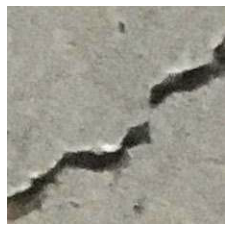

In [273]:
# have a look at a test image to determine if the filenames are in the correct order
images = batches1[0][0]
test_img_arr = images[5]

from keras.preprocessing.image import load_img, array_to_img
test_img = array_to_img(test_img_arr)
plt.imshow(test_img)
plt.axis("off");

In [370]:
# retrieve the test data filenames and sort them in ascending order
filelist1 = os.listdir('./data/A3/test_new/p1/1/')
sorted_filelist1 = filelist1.sort()
filelist2 = os.listdir('./data/A3/test_new/p2/2/')
sorted_filelist2 = filelist2.sort()
filelist3 = os.listdir('./data/A3/test_new/p3/3/')
sorted_filelist3 = filelist3.sort()
filelist4 = os.listdir('./data/A3/test_new/p4/4/')
sorted_filelist4 = filelist4.sort()
filelist5 = os.listdir('./data/A3/test_new/p5/5/')
sorted_filelist5 = filelist5.sort()
filelist6 = os.listdir('./data/A3/test_new/p6/6/')
sorted_filelist6 = filelist6.sort()

# obtain the actual classes from the filenames
y_test = []

for file in filelist6[0:30]:
    split = file.split('_')
    if(len(split)==2):
        label = split[1]
    else:
        label = split[2]
    label = label.replace('.jpg', '')
    label = int(label)
    y_test.append(label)

for file in filelist2[0:30]:
    split = file.split('_')
    if(len(split)==2):
        label = split[1]
    else:
        label = split[2]
    label = label.replace('.jpg', '')
    label = int(label)
    y_test.append(label)
    
for file in filelist3[0:30]:
    split = file.split('_')
    if(len(split)==2):
        label = split[1]
    else:
        label = split[2]
    label = label.replace('.jpg', '')
    label = int(label)
    y_test.append(label)
    
for file in filelist4[0:30]:
    split = file.split('_')
    if(len(split)==2):
        label = split[1]
    else:
        label = split[2]
    label = label.replace('.jpg', '')
    label = int(label)
    y_test.append(label)
    
for file in filelist5[0:30]:
    split = file.split('_')
    if(len(split)==2):
        label = split[1]
    else:
        label = split[2]
    label = label.replace('.jpg', '')
    label = int(label)
    y_test.append(label)
    
for file in filelist6[0:30]:
    split = file.split('_')
    if(len(split)==2):
        label = split[1]
    else:
        label = split[2]
    label = label.replace('.jpg', '')
    label = int(label)
    y_test.append(label)
print(len(y_test))

180


In [371]:
# and save them
np.savez('./data/A3/output/CNN_labels.npz', y_test)

In [372]:
# load the files
y_pred = all_preds

# calculate metrics
_, pred_freq = np.unique(y_pred, return_counts=True)
_, test_freq = np.unique(y_test, return_counts=True)

accuracy_metric = accuracy_score(y_test, y_pred)
precision_metric = precision_score(y_test, y_pred)
recall_metric = recall_score(y_test, y_pred)
auc_metric = roc_auc_score(y_test, y_pred)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
cm = confusion_matrix(y_test, y_pred)
f1_metric = f1_score(y_test, y_pred)

print("Accuracy: {}".format(round(accuracy_metric,4)))
print("Precision: {}".format(round(precision_metric,4)))
print("Recall: {}".format(round(recall_metric,4)))
print("AUC: {}".format(round(auc_metric,4)))
print("F1 score: {}".format(round(f1_metric,4)))

Accuracy: 0.8889
Precision: 0.913
Recall: 0.875
AUC: 0.8899
F1 score: 0.8936


In [373]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

[[76  8]
 [12 84]]


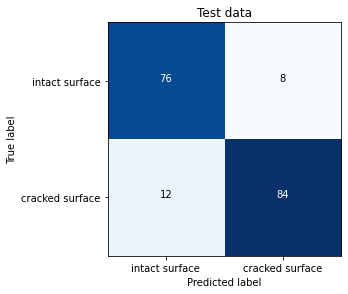

In [374]:
cm_plot_labels = ['intact surface', 'cracked surface']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Test data')